In [1]:
from __future__ import print_function



In [2]:
"""DVS128 closed loop oscillator routine by Alexander Rivkind, Eldad Assa, Michael Kreiserman and Ehud Ahissar
based on: 
*DVS example by: Yuhuang Hu (duguyue100@gmail.com)
*"Syclop" paradigm: Ahissar and Assa 2016
"""
import numpy as np
import time
import SYCLOP_env as syc
import matplotlib.pyplot as plt


import pickle
from RL_brain_b import DeepQNetwork

import cv2
import copy
from misc import *
import maestro
import sys
import os
from pyaer.dvs128 import DVS128
%matplotlib notebook

In [3]:
class Free_run_agent():
    def __init__(self,max_q = None):
        self.hp = HP()
        self.hp.action_space = ['v_right','v_left','v_up','v_down','null'] + \
                               [['v_right','v_up'],['v_right','v_down'],['v_left','v_up'],['v_left','v_down']]#'
        self.hp.max_speed  = 10
        self.q_centre = np.array([0.,0.], dtype='f') 
        self.reset()

    def reset(self):
        self.q_ana = np.array([0.,0.], dtype='f') 
        self.qdot = np.array([0.0,0.0])
        self.qdotdot = np.array([0.0,0.0])
        self.q = np.int32(np.floor(self.q_ana))

    def sync_with_servo(self,servo,orientations = [0,1]):
        for orientation in orientations:
            if not servo.isMoving(orientation):
                self.qdot[orientation]=0.0
                
            
    def act(self,a):
        if a is None:
            action = 'null'
        else:
            action = self.hp.action_space[a]
        #delta_a = 0.001
        if type(action) == list:
            for subaction in action:
                self.parse_action(subaction)
        else:
            self.parse_action(action)

        #print('debug', self.max_q, self.q_centre)
        self.qdot += self.qdotdot
        #self.qdot -= self.hp.returning_force*(self.q_ana-self.q_centre)
        self.q_ana +=self.qdot
        self.q = np.int32(np.floor(self.q_ana))

    def parse_action(self,action):
        if type(action)==int:
            self.qdot[0] = action
            self.qdotdot = np.array([0., 0.])
        elif action == 'v_up':   # up
            self.qdot[1] = self.qdot[1] + (1 if self.qdot[1] < self.hp.max_speed else 0)
            self.qdotdot = np.array([0., 0.])
        elif action == 'v_down':   # down
            self.qdot[1] = self.qdot[1] - (1 if self.qdot[1] > -self.hp.max_speed else 0)  
            self.qdotdot = np.array([0., 0.])
        elif action == 'v_left':   # left
            self.qdot[0] = self.qdot[0] - (1 if self.qdot[0] > -self.hp.max_speed else 0)  
            self.qdotdot = np.array([0., 0.])
        elif action == 'v_right':   # right
            self.qdot[0] = self.qdot[0] + (1 if self.qdot[0] < self.hp.max_speed else 0) 
            self.qdotdot = np.array([0.,0.])
        elif action == 'null':   # null
            pass
        else:
            error('unknown action')

In [4]:
import pickle

In [5]:
    hp = HP()
    hp.mem_depth=1
    hp.logmode = False
    hp.steps_between_learnings = 100
    hp.save_path = 'saved_runs'
    hp.this_run_name = sys.argv[0] + '_noname_' + str(int(time.time()))
    hp.description = "real life syclop, fixed fovea proportions"
    hp.mem_depth = 1
    hp.max_episode =  10000
    hp.steps_per_episode = 1000
    hp.steps_between_learnings = 100
    hp.fading_mem = 0.5
    recorder_file = 'records.pkl'
    hp_file = 'hp.pkl'
    hp.contrast_range = [1.0,1.1]
    hp.logmode = False
#     recorder = Recorder(n=4)




    if not os.path.exists(hp.save_path):
        os.makedirs(hp.save_path)

    hp.this_run_path = hp.save_path+'/'+hp.this_run_name+'/'
    if not os.path.exists(hp.this_run_path):
        os.makedirs(hp.this_run_path)
    else:
        error('run name already exists!')



    import pickle

    sensor = syc.Sensor()
    agent = Free_run_agent()

    reward = syc.Rewards()
    observation_size = 256*4
    RL = DeepQNetwork(len(agent.hp.action_space), observation_size*hp.mem_depth,#sensor.frame_size+2,
                      reward_decay=0.99,
                      e_greedy=0.95,
                      e_greedy0=0.95,
                      replace_target_iter=10,
                      memory_size=100000,
                      e_greedy_increment=0.0001,
                      learning_rate=0.0025,
                      double_q=False,
                      dqn_mode=True,
                      state_table=np.zeros([1,observation_size*hp.mem_depth])
                      )
#     RL.dqn.load_nwk_param('saved_runs/run_syclop_lirondb.py_noname_1557658952/best_liron.nwk')
#     RL.dqn.load_nwk_param('zhoka.nwk')
#     RL.dqn.load_nwk_param('saved_runs/old_flat_saves/liron_random_ic05.nwk')

In [6]:
servo = maestro.Controller(ttyStr='/dev/ttyACM1')

In [8]:
servo.natural_bottom = 8384
servo.constrained_top = 7500 - servo.natural_bottom + 7500
servo.setRange(1, servo.constrained_top, servo.natural_bottom )

In [9]:
def gohome():    
    servo.setSpeed(0,0)
    servo.setSpeed(1,0)
    servo.setTarget(1,7500)     #set speed of servo 1
    servo.setTarget(0,5000)  #set servo to move to center position
    servo.setSpeed(0,1)
    servo.setSpeed(1,1)
    time.sleep(1.0)

In [10]:
gohome()

In [11]:
servo.moveByVelocity(1,3)

In [12]:
def local_observer(sensor,agent):
    if hp.logmode:
        normfactor=1.0
    else:
        normfactor = 1.0/1.0
    return normfactor*np.concatenate([relu_up_and_down(sensor.central_dvs_view),
            relu_up_and_down(cv2.resize(1.0*sensor.dvs_view, dsize=(16, 16), interpolation=cv2.INTER_AREA))])

observation = np.random.uniform(0,1,size=[hp.mem_depth, observation_size])
hp.fading_mem = 0.5
recorder = Recorder(n=6)

going home!
step 0
saved best network, mean reward:  0.007552411067475919
saved best network, mean reward:  0.018306085150418674
saved best network, mean reward:  0.022337236165008427
saved best network, mean reward:  0.02914380045041533
saved best network, mean reward:  0.029955245880094954
saved best network, mean reward:  0.03033172985002759
0 1000  running reward    0.03033172985002759
going home!
step 1000
saved best network, mean reward:  0.04224811372114951
saved best network, mean reward:  0.047142569599573414
saved best network, mean reward:  0.057413699936718236
saved best network, mean reward:  0.06490123723289276
1 2000  running reward    0.048086830253484224
going home!
step 2000
2 3000  running reward    0.03293488910143783
going home!
step 3000
3 4000  running reward    0.021550480707020293
going home!
step 4000
4 5000  running reward    0.054629513733950974
going home!
step 5000
saved best network, mean reward:  0.06580028238507406
5 6000  running reward    0.0306317885

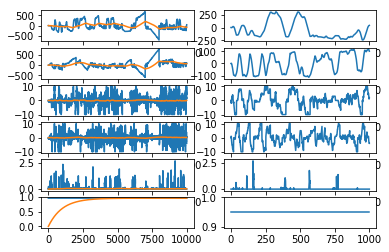

9 10000  running reward    0.02854090064169743
going home!
step 10000
10 11000  running reward    0.016133761066952673
going home!
step 11000
11 12000  running reward    0.021712157464560237
going home!
step 12000
12 13000  running reward    0.01025543815051059
going home!
step 13000
13 14000  running reward    0.010317997836284468
going home!
step 14000
14 15000  running reward    0.023433474149574047
going home!
step 15000
15 16000  running reward    0.020975101410719562
going home!
step 16000
16 17000  running reward    0.025224481022244352
going home!
step 17000
17 18000  running reward    0.02827101341673898
going home!
step 18000
saved best network, mean reward:  0.0700148371313422
18 19000  running reward    0.0700148371313422
going home!
step 19000
19 20000  running reward    0.033110076354304636
going home!
step 20000
20 21000  running reward    0.03948328447407907
going home!
step 21000
21 22000  running reward    0.05155885285421077
going home!
step 22000
22 23000  running r

going home!
step 122000
122 123000  running reward    0.004879350320471736
going home!
step 123000
123 124000  running reward    0.003816413937727728
going home!
step 124000
124 125000  running reward    0.0033097879486590595
going home!
step 125000
125 126000  running reward    0.008962920103072477
going home!
step 126000
126 127000  running reward    0.015336585000983996
going home!
step 127000
127 128000  running reward    0.012047783307256867
going home!
step 128000
128 129000  running reward    0.006146486951139439
going home!
step 129000
129 130000  running reward    0.008502657851149079
going home!
step 130000
130 131000  running reward    0.014015343215740151
going home!
step 131000
131 132000  running reward    0.009673393127358857
going home!
step 132000
132 133000  running reward    0.008210056361840249
going home!
step 133000
133 134000  running reward    0.004259191873367139
going home!
step 134000
134 135000  running reward    0.011941916052442958
going home!
step 135000


going home!
step 232000
232 233000  running reward    0.007131923280966401
going home!
step 233000
233 234000  running reward    0.008788870572291763
going home!
step 234000
234 235000  running reward    0.008619499290049558
going home!
step 235000
235 236000  running reward    0.010849269275668058
going home!
step 236000
236 237000  running reward    0.022050861053968154
going home!
step 237000
237 238000  running reward    0.021262090975005515
going home!
step 238000
238 239000  running reward    0.017305101043183842
going home!
step 239000
239 240000  running reward    0.01073862844141039
going home!
step 240000
240 241000  running reward    0.01538489990575303
going home!
step 241000
241 242000  running reward    0.010633089777893267
going home!
step 242000
242 243000  running reward    0.03120457863003053
going home!
step 243000
243 244000  running reward    0.016803653723317314
going home!
step 244000
244 245000  running reward    0.016613860111280125
going home!
step 245000
245 

saved best network, mean reward:  0.14900525809986298
saved best network, mean reward:  0.1501595528644502
saved best network, mean reward:  0.16258229031164906
saved best network, mean reward:  0.18269219702507977
334 335000  running reward    0.18269219702507977
going home!
step 335000
saved best network, mean reward:  0.18506740945567454
saved best network, mean reward:  0.18907047507591468
335 336000  running reward    0.17558911641556488
going home!
step 336000
336 337000  running reward    0.08972525610443531
going home!
step 337000
337 338000  running reward    0.09180744607849176
going home!
step 338000
338 339000  running reward    0.11048150824236386
going home!
step 339000
339 340000  running reward    0.14197559303386298
going home!
step 340000
340 341000  running reward    0.14361715882244902
going home!
step 341000
341 342000  running reward    0.14560087703225325
going home!
step 342000
342 343000  running reward    0.09655070507392646
going home!
step 343000
343 344000 

going home!
step 438000
438 439000  running reward    0.023993215874056235
going home!
step 439000
439 440000  running reward    0.017536615349052067
going home!
step 440000
440 441000  running reward    0.017444288447304127
going home!
step 441000
441 442000  running reward    0.021462770960209907
going home!
step 442000
442 443000  running reward    0.012639922465230496
going home!
step 443000
443 444000  running reward    0.017971895068667733
going home!
step 444000
444 445000  running reward    0.02135056239712295
going home!
step 445000
445 446000  running reward    0.018469510090590252
going home!
step 446000
446 447000  running reward    0.019840371570901988
going home!
step 447000
447 448000  running reward    0.015437323421205922
going home!
step 448000
448 449000  running reward    0.019444786363365975
going home!
step 449000
449 450000  running reward    0.013073345679626973
going home!
step 450000
450 451000  running reward    0.02003457492752835
going home!
step 451000
451

going home!
step 548000
548 549000  running reward    0.024586559547492132
going home!
step 549000
549 550000  running reward    0.03888215824900286
going home!
step 550000
550 551000  running reward    0.04163348646555558
going home!
step 551000
551 552000  running reward    0.02173930917289524
going home!
step 552000
552 553000  running reward    0.01544813228862438
going home!
step 553000
553 554000  running reward    0.018389873547712442
going home!
step 554000
554 555000  running reward    0.010965778702724383
going home!
step 555000
555 556000  running reward    0.019450213101935263
going home!
step 556000
556 557000  running reward    0.01849146099305329
going home!
step 557000
557 558000  running reward    0.01794457449769952
going home!
step 558000
558 559000  running reward    0.027116896399353003
going home!
step 559000
559 560000  running reward    0.02443020151126922
going home!
step 560000
560 561000  running reward    0.026152915401291835
going home!
step 561000
561 5620

going home!
step 658000
658 659000  running reward    0.02003454287521875
going home!
step 659000
659 660000  running reward    0.026100466653096017
going home!
step 660000
660 661000  running reward    0.026876112232407202
going home!
step 661000
661 662000  running reward    0.02510720252012735
going home!
step 662000
662 663000  running reward    0.01407471715108631
going home!
step 663000
663 664000  running reward    0.016683182253585185
going home!
step 664000
664 665000  running reward    0.017146073874910323
going home!
step 665000
665 666000  running reward    0.02040691928604432
going home!
step 666000
666 667000  running reward    0.02093371737910471
going home!
step 667000
667 668000  running reward    0.026394078620918138
going home!
step 668000
668 669000  running reward    0.02133169440483778
going home!
step 669000
669 670000  running reward    0.016420611895044828
going home!
step 670000
670 671000  running reward    0.010540047207196505
going home!
step 671000
671 672

768 769000  running reward    0.02451815403612355
going home!
step 769000
769 770000  running reward    0.0221844336915173
going home!
step 770000
770 771000  running reward    0.02223898740657715
going home!
step 771000
771 772000  running reward    0.029565380518263074
going home!
step 772000
772 773000  running reward    0.03119758056463069
going home!
step 773000
773 774000  running reward    0.03764227762427091
going home!
step 774000
774 775000  running reward    0.034966655393279866
going home!
step 775000
775 776000  running reward    0.016392534707739805
going home!
step 776000
776 777000  running reward    0.018612162989454402
going home!
step 777000
777 778000  running reward    0.017086182684866513
going home!
step 778000
778 779000  running reward    0.014900937599120149
going home!
step 779000
779 780000  running reward    0.04073030652580163
going home!
step 780000
780 781000  running reward    0.035677770869500795
going home!
step 781000
781 782000  running reward    0.

878 879000  running reward    0.03062691151484159
going home!
step 879000
879 880000  running reward    0.02189798542896773
going home!
step 880000
880 881000  running reward    0.02192915365665389
going home!
step 881000
881 882000  running reward    0.030368265158284963
going home!
step 882000
882 883000  running reward    0.03362217841053582
going home!
step 883000
883 884000  running reward    0.026231882131078164
going home!
step 884000
884 885000  running reward    0.035703628619213196
going home!
step 885000
885 886000  running reward    0.047304031152173125
going home!
step 886000
886 887000  running reward    0.039445880414490174
going home!
step 887000
887 888000  running reward    0.05617929409307887
going home!
step 888000
888 889000  running reward    0.044541080120720736
going home!
step 889000
889 890000  running reward    0.017394933115396423
going home!
step 890000
890 891000  running reward    0.02654923985985727
going home!
step 891000
891 892000  running reward    0

988 989000  running reward    0.027046623428742776
going home!
step 989000
989 990000  running reward    0.03939497920974567
going home!
step 990000
990 991000  running reward    0.025594990788437074
going home!
step 991000
991 992000  running reward    0.027602820738950196
going home!
step 992000
992 993000  running reward    0.018784769048100107
going home!
step 993000
993 994000  running reward    0.02445577007280521
going home!
step 994000
994 995000  running reward    0.01888915088753428
going home!
step 995000
995 996000  running reward    0.020033192146242575
going home!
step 996000
996 997000  running reward    0.028244140822196208
going home!
step 997000
997 998000  running reward    0.027924547153018165
going home!
step 998000
998 999000  running reward    0.035917623829690215
going home!
step 999000
999 1000000  running reward    0.016053536893102297
going home!
step 1000000
1000 1001000  running reward    0.01807616861376922
going home!
step 1001000
1001 1002000  running re

going home!
step 1095000
1095 1096000  running reward    0.014423175989167392
going home!
step 1096000
1096 1097000  running reward    0.026547630549607047
going home!
step 1097000
1097 1098000  running reward    0.04031840021200338
going home!
step 1098000
1098 1099000  running reward    0.032839049037154316
going home!
step 1099000
1099 1100000  running reward    0.036172754303672526
going home!
step 1100000
1100 1101000  running reward    0.02184377702764677
going home!
step 1101000
1101 1102000  running reward    0.02377663702117882
going home!
step 1102000
1102 1103000  running reward    0.02536780818756843
going home!
step 1103000
1103 1104000  running reward    0.04746434734961643
going home!
step 1104000
1104 1105000  running reward    0.03851700436027442
going home!
step 1105000
1105 1106000  running reward    0.030889347545353135
going home!
step 1106000
1106 1107000  running reward    0.03125940154167585
going home!
step 1107000
1107 1108000  running reward    0.034408592577

going home!
step 1201000
1201 1202000  running reward    0.04482666460841279
going home!
step 1202000
1202 1203000  running reward    0.030269942926816444
going home!
step 1203000
1203 1204000  running reward    0.017673845971178596
going home!
step 1204000
1204 1205000  running reward    0.014293868220581454
going home!
step 1205000
1205 1206000  running reward    0.014762283242453432
going home!
step 1206000
1206 1207000  running reward    0.020316731037074345
going home!
step 1207000
1207 1208000  running reward    0.019871619748220805
going home!
step 1208000
1208 1209000  running reward    0.04836676723910963
going home!
step 1209000
1209 1210000  running reward    0.020903697964171613
going home!
step 1210000
1210 1211000  running reward    0.01806251932013756
going home!
step 1211000
1211 1212000  running reward    0.016316154370216534
going home!
step 1212000
1212 1213000  running reward    0.014090761173112558
going home!
step 1213000
1213 1214000  running reward    0.00749176

TypeError: 'NoneType' object is not iterable

In [13]:
training = True
device = DVS128()


device.start_data_stream()
# load new config
# device.set_bias_from_json("./scripts/configs/dvs128_config.json")
# print (device.get_bias())

clip_value = 3
histrange = [(0, v) for v in (128, 128)]
t_prev = time.time()
dt_nom = 0.025
episode = 0
# dt_list = []
cnt = 0
empty_cnt = 0
best_thus_far = 0.0
step = 0 
observation = np.random.uniform(0,1,size=[hp.mem_depth, observation_size])
observation_ = np.random.uniform(0,1,size=[hp.mem_depth, observation_size])
running_ave_reward = 0
agent.reset()
t0 = time.time()
for episode in range(hp.max_episode):
    gohome()
    print('going home!')

    observation = 0*local_observer(sensor, agent)
    observation_ = 0*local_observer(sensor, agent)
    agent.reset()
    step_prime=0
    while step_prime < hp.steps_per_episode:
        t_this = time.time()
        try:
            (pol_events, num_pol_event,
             special_events, num_special_event) = \
                device.get_event("events_hist")
            if t_this - t_prev > dt_nom:
                    t_prev=t_this
                    if num_pol_event != 0:
                        img = pol_events[..., 1]-pol_events[..., 0]
                        cv2.imshow("image", np.flip(np.flip( img/float(clip_value*2),axis=0),axis=1))

                        action = RL.choose_action(observation.reshape([-1]))
                        reward.update_rewards(sensor = sensor, agent = agent)
                        running_ave_reward = 0.999*running_ave_reward+0.001*reward.reward
    #                     reward.update_rewards(sensor = sensor, agent = agent)
                        recorder.record([agent.q_ana[0],agent.q_ana[1], agent.qdot[0],agent.qdot[1],reward.reward,RL.epsilon])
                        agent.sync_with_servo(servo)
                        agent.act(action)
                        for orientation in [0,1]:
                            servo.moveByVelocity(orientation,(int(np.round(agent.qdot[orientation]))))
                        sensor.dvs_view = cv2.resize(1.0*img, dsize=(64, 64))
                        #note fixing fovea size
                        sensor.central_dvs_view = cv2.resize(1.0*img[64-16:64:16,64-16:64+16], dsize=(16, 16))
                        if step_prime == 0:
                            sensor.dvs_view *= 0.
                            sensor.central_dvs_view *= 0.
    #                     print(np.min(sensor.dvs_view ),np.max(sensor.dvs_view ) )
                        observation_ *= hp.fading_mem
                        observation_ += local_observer(sensor, agent)  # todo: generalize
                        if step%1000 ==0:
                            print('step',step)
                        RL.store_transition(observation.reshape([-1]), action, reward.reward, observation_.reshape([-1]))
                        observation = copy.copy(observation_)
                        step += 1
                        step_prime +=1
                        if  (step > 100) and (step % hp.steps_between_learnings == 0):
                            t_pre=time.time()
                            RL.learn()
                            t_post=time.time()
                            if running_ave_reward > best_thus_far:
                                best_thus_far = running_ave_reward
                                RL.dqn.save_nwk_param(hp.this_run_path+'best_live.nwk')
                                print('saved best network, mean reward: ', best_thus_far)
#                             print('training took', t_post-t_pre)
                        if step%10000 ==0:
                            recorder.plot()
                            RL.dqn.save_nwk_param(hp.this_run_path+'tempX_1.nwk')
                    # debug_policy_plot()
                        if step % 100000 == 0:
                                recorder.save(hp.this_run_path+recorder_file)
                        if step%1000 ==0:
                            print(episode,step,' running reward   ',running_ave_reward)

        except KeyboardInterrupt:
                device.shutdown()
                break
            

In [14]:
RL.dqn.save_nwk_param('zhokaXX.nwk')


In [16]:
device.shutdown()

In [15]:
hp.this_run_path+'best_live.nwk'

'saved_runs//usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py_noname_1558948584/best_live.nwk'